In [ ]:
!pip uninstall gym stable-baselines3
!pip install gym
!pip install stable-baselines3[extra]
!pip install stable-baselines3
!pip install keras-rl2

Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/gym-0.25.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/gym/*
Proceed (Y/n)? n
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 31.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.6 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=39fccca84e733e30ae7288c2cd7e2c4e2f0d9f700228ffca3c41e94af440f9cb
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2

In [ ]:
import numpy as np
import os
import random
import gym
from gym import spaces

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers.legacy import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

# Word list preprocessing
words_list_path = r'/content/word_list.txt'
f = open(words_list_path, 'r')
words_list = list(f.readlines())
words_list = [word.strip('1234567890,. \n .\' -') for word in words_list]
wordle_word_list = [word for word in words_list if len(word) == 5]
wordle_word_list = [word for word in wordle_word_list if not any(ele.isupper() for ele in word)]

# Game functions

def wordle_obs_from_words(board, word, guess_word, turn_num):
    obs = np.zeros(5)
    for ind, (i, j) in enumerate(zip(word, guess_word)):
        if i == j:
            obs[ind] = 1
        else:
            if j in word:
                obs[ind] = -1
    board[turn_num] = obs
    return board

def wordle_score_guess(word, guess_word):
    if word == guess_word:
        return 100  # Correctly guessed the word
    score = sum([10 if i == j else (5 if j in word else -10) for i, j in zip(word, guess_word)])
    return max(score, 0)

# Environment
class WordleEnv(gym.Env):

    def __init__(self, wordle_word_list):
        self.board = np.zeros((6, 5))
        self.last_guess = None
        self.wordle_word_list = wordle_word_list
        self.action_space = spaces.Discrete(len(self.wordle_word_list))
        self.observation_space = spaces.Box(low=-1, high=1, shape=self.board.shape)
        self.reset()

    def reset(self):
        self.word = random.choice(self.wordle_word_list)
        self.board *= 0
        self.turn = 0
        self.last_guess = None
        return self.board

    def step(self, action):
        guess_word = self.wordle_word_list[action]
        self.board = wordle_obs_from_words(self.board, self.word, guess_word, self.turn)
        reward = wordle_score_guess(self.word, guess_word)
        if guess_word == self.last_guess:
            reward -= 5  # Penalize repeating the same guess
        self.last_guess = guess_word
        self.turn += 1
        done = self.turn >= 6 or reward == 100
        return self.board, reward, done, {}

    def render(self, mode='human'):
        print(self.last_guess,self.word)
        print(self.board)

env = WordleEnv(wordle_word_list)

# Deep Q Network

model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(env.action_space.n))

# Memory
memory = SequentialMemory(limit=50000, window_length=1)

policy = BoltzmannQPolicy()


In [ ]:
dqn = DQNAgent(model=model, nb_actions=env.action_space.n, memory=memory, policy=policy)
dqn.compile(Adam(learning_rate=0.001), metrics=['mae'])
# Training
dqn.fit(env, nb_steps=30000, verbose=2)

In [ ]:
dqn.fit(env, nb_steps=30000, verbose=2)

Streaming output truncated to the last 5000 lines.
    18/30000: episode: 3, duration: 0.022s, episode steps:   6, steps per second: 275, episode reward: -5.000, mean reward: -0.833 [-5.000,  0.000], mean action: 2685.333 [852.000, 4833.000],  loss: --, mae: --, mean_q: --
    24/30000: episode: 4, duration: 0.015s, episode steps:   6, steps per second: 398, episode reward: 20.000, mean reward:  3.333 [-5.000, 25.000], mean action: 3348.333 [249.000, 5608.000],  loss: --, mae: --, mean_q: --
    30/30000: episode: 5, duration: 0.017s, episode steps:   6, steps per second: 354, episode reward:  0.000, mean reward:  0.000 [ 0.000,  0.000], mean action: 3180.167 [243.000, 5331.000],  loss: --, mae: --, mean_q: --
    36/30000: episode: 6, duration: 0.015s, episode steps:   6, steps per second: 397, episode reward:  5.000, mean reward:  0.833 [ 0.000,  5.000], mean action: 2113.333 [451.000, 4332.000],  loss: --, mae: --, mean_q: --
    42/30000: episode: 7, duration: 0.015s, episode steps

In [ ]:
# Save the DQN agent
dqn.save_weights("dqn_weights.h5f", overwrite=True)


In [ ]:
# Load the DQN agent
dqn.load_weights("dqn_weights.h5f")

Testing for 100 episodes ...
melee tawny
[[ 0.  0.  0.  0.  0.]
 [ 0. -0.  0.  0. -0.]
 [-0. -0. -0.  0.  0.]
 [ 0.  0.  0. -0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
melee tawny
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [-0. -0. -0.  0.  0.]
 [ 0.  0.  0. -0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
melee tawny
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0. -0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
melee tawny
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
melee tawny
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
melee tawny
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Episode 1: reward: -25.000, steps: 6
melee murks
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Streaming output truncated to the last 5000 lines.
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Episode 84: reward: -5.000, steps: 6
melee talky
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
seeds talky
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
seeds talky
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
seeds talky
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
seeds talky
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
seeds talky
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Episode 85: reward: -20.000, steps: 6
melee chaos
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0

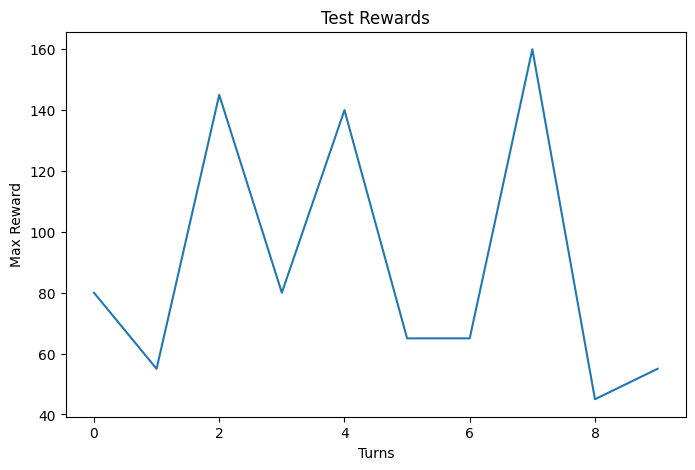

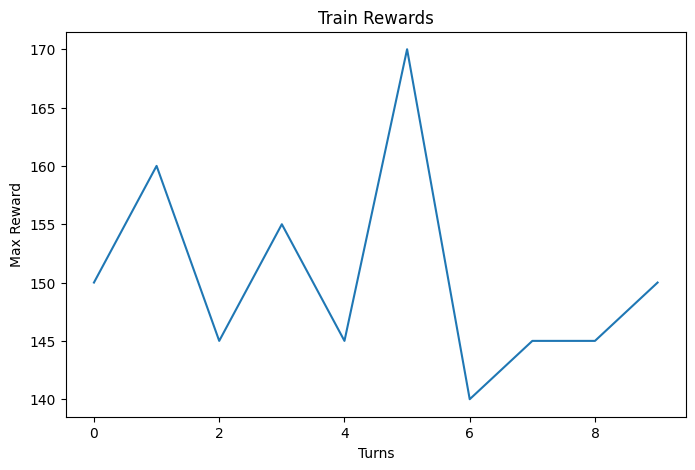

In [ ]:
import matplotlib.pyplot as plt

test_rewards = []
train_rewards = []
tst = []
trn = []

for i in range(10):

  test_history = dqn.test(env, nb_episodes=100)
  max_test_reward = np.max(test_history.history['episode_reward'])
  test_rewards.append(max_test_reward)
  if max_test_reward >= 100:
    tst.append(test_history)

  dqn.fit(env, nb_steps=1000)
  max_train_reward = np.max(dqn.history.history['episode_reward'])
  train_rewards.append(max_train_reward)
  if max_train_reward >= 100:
    trn.append(dqn.history)

# Plot test rewards
plt.figure(figsize=(8, 5))
plt.plot(test_rewards)
plt.title('Test Rewards')
plt.xlabel('Turns')
plt.ylabel('Max Reward')
plt.show()

# Plot train rewards
plt.figure(figsize=(8, 5))
plt.plot(train_rewards)
plt.title('Train Rewards')
plt.xlabel('Turns')
plt.ylabel('Max Reward')
plt.show()


In [ ]:
# Store max reward episodes
max_test_episodes = [h for h in tst if np.max(h.history['episode_reward']) >= 100]
max_train_episodes = [h for h in trn if np.max(h.history['episode_reward']) >= 100]

print("Number of max test reward episodes:", len(max_test_episodes))
print("Number of max train reward episodes:", len(max_train_episodes))

Number of max test reward episodes: 3
Number of max train reward episodes: 10
